# Example 5. Titanic Survival Prediction using MLP

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.optim import SGD
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import metrics
import pandas as pd
import matplotlib.pyplot as plt
from torchview import draw_graph
from IPython.display import clear_output, display

## 0. Dataset

In [2]:
import kagglehub
from pathlib import Path

# Download latest version
path = Path(kagglehub.dataset_download("yasserh/titanic-dataset"))

print("Path to dataset files:", path)

/users/seyang/opt/micromamba/envs/lec-25-1-sju-ml-py312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /users/seyang/.cache/kagglehub/datasets/yasserh/titanic-dataset/versions/1


In [3]:
df = pd.read_csv(path / 'Titanic-Dataset.csv',)

In [4]:
df = df.drop(columns=['Name', 'Ticket', 'Cabin', 'PassengerId'])

In [5]:
df['Age'] = df['Age'].replace(float('nan'), df['Age'].median())
df['Embarked'] = df['Embarked'].replace(float('nan'), df['Embarked'].mode()[0])

In [6]:
df['Sex'] = LabelEncoder().fit_transform(df['Sex'])
df['Embarked'] = LabelEncoder().fit_transform(df['Embarked'])

In [7]:
x_total = df.drop('Survived', axis=1).to_numpy().astype(np.float32)
t_total = df['Survived'].to_numpy().astype(np.int64)

In [8]:
x_train_val, x_test, t_train_val, t_test = train_test_split(x_total, t_total, test_size=0.2)
x_train, x_val, t_train, t_val = train_test_split(x_train_val, t_train_val, test_size=0.2)

x_scaler = StandardScaler()

x_train_scaled = x_scaler.fit_transform(x_train)
x_val_scaled = x_scaler.transform(x_val)
x_test_scaled = x_scaler.transform(x_test)

In [9]:
x_train_scaled = torch.from_numpy(x_train_scaled)
x_val_scaled = torch.from_numpy(x_val_scaled)
x_test_scaled = torch.from_numpy(x_test_scaled)

t_train = torch.from_numpy(t_train)
t_val = torch.from_numpy(t_val)
t_test = torch.from_numpy(t_test)

In [10]:
train_set = TensorDataset(x_train_scaled, t_train)
val_set = TensorDataset(x_val_scaled, t_val)
test_set = TensorDataset(x_test_scaled, t_test)

## 1. Define a small MLP

In [ ]:
num_features = train_set[0][0].size(0)

model = nn.Sequential(
    nn.Linear(in_features=num_features, out_features=32, bias=True),
    nn.ReLU(),
    nn.Linear(in_features=32, out_features=1, bias=True),
)

In [12]:
print(model)

Sequential(
  (0): Linear(in_features=7, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=1, bias=True)
)


## 2. Optimization Criterion, Optimzer, and Data Loaders

In [14]:
criterion = nn.BCEWithLogitsLoss(reduction='mean')

In [15]:
optimizer = SGD(params=model.parameters(), lr=0.1)

In [16]:
# DataLoader for training: shuffles data
train_loader = DataLoader(
    dataset=train_set,
    batch_size=64,
    shuffle=True,
    drop_last=True, # drop last incomplete batch if any
)

# DataLoader for validation: no shuffling, keep all data
val_loader = DataLoader(
    dataset=val_set,
    batch_size=64,
    shuffle=False,
    drop_last=False,
)

## 3. Fit

In [17]:
def plot_curve(
    train_loss_step, 
    train_loss,
    train_acc_step,
    train_acc,
    val_step,
    val_loss,
    val_acc,
) -> None:
    """
    """
    clear_output(wait=True)
    fig, (ax_loss, ax_acc) = plt.subplots(figsize=(10, 5), ncols=2)
    
    ax_loss.plot(train_loss_step, train_loss, label='Training', ls=':', marker='o')
    ax_loss.plot(val_step, val_loss, label='Validation', ls='--', marker='s')
    ax_loss.set_xlabel(r'Step')
    ax_loss.set_ylabel(r'Binary Cross Entropy')
    ax_loss.legend()

    ax_acc.plot(train_acc_step, train_acc, label='Training', ls=':', marker='o')
    ax_acc.plot(val_step, val_acc, label='Validation', ls='--', marker='s')
    ax_acc.set_xlabel(r'Epoch')
    ax_acc.set_ylabel(r'Accuracy')
    ax_acc.legend()
    
    display(fig)
    plt.close(fig)

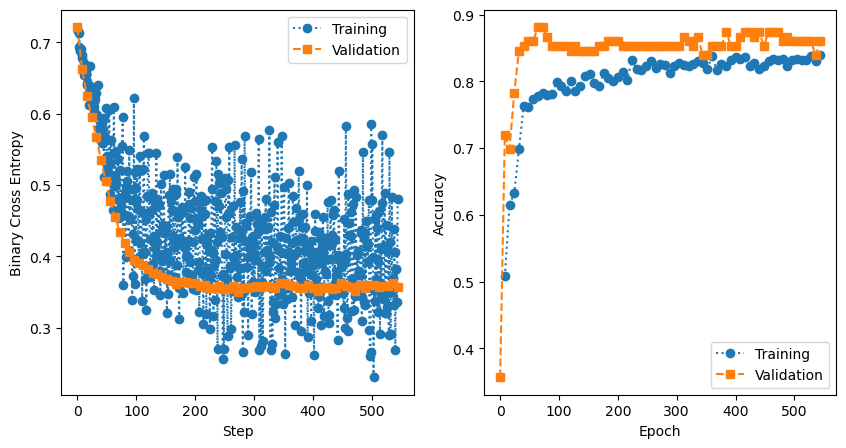

In [ ]:
# prepare lists for plotting
train_loss_step_list = []
train_loss_list = []

train_acc_step_list = []
train_acc_list = []

val_step_list = []
val_loss_list = []
val_acc_list = []

step = 0

max_epochs = 100
threshold = 0.5

for epoch in range(0, max_epochs + 1):

    if epoch > 0:
        # training

        train_total = 0
        train_correct = 0

        model.train()
        for x, t in train_loader:
            y_logits = model(x).squeeze()
            loss = criterion(input=y_logits, target=t.float())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            step += 1

            y_score = y_logits.sigmoid()
            y_pred = y_score >= threshold
            train_total += len(x)
            train_correct += (y_pred == t).sum().item()

            train_loss_step_list.append(step)
            train_loss_list.append(loss.item())

        train_acc_step_list.append(step)
        train_acc_list.append(train_correct / train_total)
    
    # validation
    val_loss_sum = 0
    val_total = 0
    val_correct = 0
    
    model.eval()
    with torch.inference_mode(): # disable gradient computation for validation
        for x, t in val_loader:
            y_logits = model(x).squeeze()
            y_score = y_logits.sigmoid()
            y_pred = y_score >= threshold
            loss = criterion(input=y_logits, target=t.float())

            val_total += len(x)
            val_loss_sum += loss.item() * len(x)
            val_correct += (y_pred == t).sum().item()

    val_step_list.append(step)
    val_loss_list.append(val_loss_sum / val_total)
    val_acc_list.append(val_correct / val_total)

    plot_curve(train_loss_step_list, train_loss_list, train_acc_step_list, train_acc_list, val_step_list, val_loss_list, val_acc_list)

## 4. Testing

In [ ]:
test_loader = DataLoader(
    dataset=test_set,
    batch_size=64,
    shuffle=False,
    drop_last=False,
)

In [ ]:
# scikit-learn notation
y_score_arr = []
y_true_arr = []

model.eval()
with torch.inference_mode(): # disable gradient computation for validation
    for x, t in test_loader:
        y_logits = model(x).squeeze()
        y_score = y_logits.sigmoid()
        y_pred = y_score >= threshold

        y_score_arr.append(y_score.numpy())
        y_true_arr.append(t.numpy())

y_score_arr = np.concatenate(y_score_arr)
y_true_arr = np.concatenate(y_true_arr)

In [ ]:
fpr, tpr, threshold_arr = metrics.roc_curve(
    y_true=y_true_arr,
    y_score=y_score_arr,
)

In [ ]:
tnr = 1 - fpr

In [ ]:
roc_auc = metrics.auc(tpr, tnr)

In [ ]:
fig, ax = plt.subplots()
ax.plot(tpr, tnr, label=f'MLP (ROC AUC = {roc_auc:.3f})', color='tab:orange')
ax.plot([0, 1], [1, 0], label='Random Classifier (ROC AUC = 0.500)', color='tab:gray', ls=':')
ax.set_xlabel(r'$TPR=\frac{True\ Positive}{Positive}$')
ax.set_ylabel(r'$TNR=\frac{True\ Negative}{Negative}$')
ax.legend()